In [1]:
import os
import random
import numpy as np
import yfinance as yf
import torch.nn as nn
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

# SEED = 2023
# random.seed(SEED)
# np.random.seed(SEED)

# Assess trend following strategy via a class

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class TF(nn.Module):
    def __init__(self, ticker, start_date, end_date, riskfree_rate=0.04):
        super(TF, self).__init__()
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.riskfree_rate = riskfree_rate
        self.stock = self.get_stock_data()
    
    def get_stock_data(self):
        print("===== DOWNLOADING STOCK DATA =====")
        df = yf.download(['GOOG'], start=self.start_date, end=self.end_date)['Adj Close']
        print("===== DOWNLOAD COMPLETE =====")

        return pd.DataFrame(df)
    
    def forward(self, sma_len1, sma_len2):
        # add sma columns
        stock_df = self.stock.copy()
        stock_df["sma1"] = stock_df['Adj Close'].rolling(sma_len1).mean()
        stock_df["sma2"] = stock_df['Adj Close'].rolling(sma_len2).mean()
        # drop na
        stock_df.dropna(inplace=True)
        # log returns of the Buy and Hold strategy
        stock_df['log_return_buy_n_hold'] = np.log(stock_df['Adj Close'] / stock_df['Adj Close'].shift(1))
        # identify buy and sell signal
        stock_df['signal'] = np.where(stock_df["sma1"] > stock_df["sma2"], 1, 0)
        stock_df['signal'] = np.where(stock_df["sma1"] < stock_df["sma2"], -1, stock_df['signal'])
        stock_df.dropna(inplace=True)
        # calculate instantaneous log return for trend following straetegy
        stock_df['log_return_trend_follow'] = stock_df['signal'] * stock_df['log_return_buy_n_hold']
        # calculate annualized return of trend following
        annualized_return_trend_follow = np.exp(stock_df['log_return_trend_follow']).prod()**(252/stock_df.shape[0])-1
        # calculate annualized volatility of trend following
        annualized_vol_trend_follow = (np.exp(stock_df['log_return_trend_follow'])-1).std()*(252**0.5)
        # calculate Sharpe ratio of trend following
        sharpe_ratio_trend_follow = (annualized_return_trend_follow - self.riskfree_rate) / annualized_vol_trend_follow
        
        return sharpe_ratio_trend_follow

In [4]:
tf = TF(ticker="GOOG", start_date="2022-01-01", end_date="2023-01-01",riskfree_rate=0.01)

===== DOWNLOADING STOCK DATA =====
[*********************100%***********************]  1 of 1 completed
===== DOWNLOAD COMPLETE =====


In [5]:
tf.stock.head()

,Adj Close
Date,
2022-01-03,145.074493
2022-01-04,144.416504
2022-01-05,137.653503
2022-01-06,137.550995
2022-01-07,137.004501


In [7]:
tf(sma_len1=5, sma_len2=10)

-0.13679432226325278

In [8]:
tf(sma_len1=3, sma_len2=20)

0.6986180655069301

# Stationarity

In [9]:
# generate random samples from normal distribution
def generate_normal_sample(params):
    """
    input: 
      params: including mean in params[0] and standard deviation in params[1]
    output: a random sample from the normal distribution parameterized by the input
    """
    mean = params[0]
    sd = params[1]
    return np.random.normal(mean, sd)

In [10]:
# generate sample from standard norml
print(generate_normal_sample([0,1]))

-0.3654411548927827


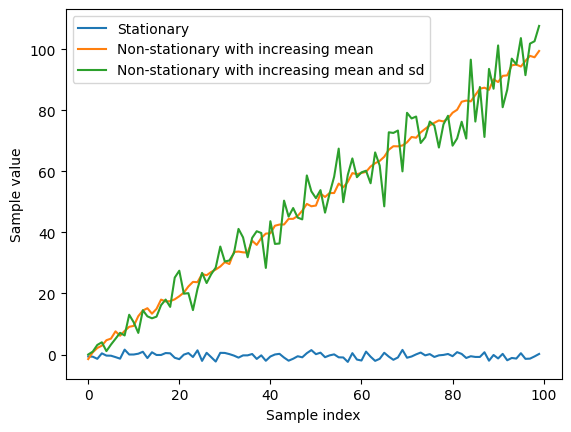

In [14]:
# generate 100 random samples for both stationary and non-stationary distribution
T = 100
stationary_list, nonstationary_list1, nonstationary_list2 = [], [], []

for i in range(T):
    # generate a stationary sample and append to list
    stationary_list.append(generate_normal_sample([0,1]))
    # generate a non-stationary sample with an increasing mean and append to list
    nonstationary_list1.append(generate_normal_sample([i,1]))
    # # generate a non-stationary sample with an increasing mean and sd and append to list
    nonstationary_list2.append(generate_normal_sample([i,np.sqrt(i)]))

x = range(T)
# plot the lists as line plots with labels for each line
plt.plot(x, stationary_list, label='Stationary')
plt.plot(x, nonstationary_list1, label='Non-stationary with increasing mean')
plt.plot(x, nonstationary_list2, label='Non-stationary with increasing mean and sd')

# set the axis labels
plt.xlabel('Sample index')
plt.ylabel('Sample value')
# add a legend
plt.legend()
# show the plot
plt.show()

In [15]:
# test for stationarity
def stationarity_test(x, threshold=0.05):
    """
    input: 
      x: a list of scalar values
      threshold: significance level
    output: print out message on stationarity
    """
    pvalue = adfuller(x)[1]
    if pvalue < threshold:
        return 'p-value is ' + str(pvalue) + '. The series is likely stationary.'
    else:
        return 'p-value is ' + str(pvalue) + '. The series is likely non-stationary.'

In [16]:
print(stationarity_test(stationary_list))
print(stationarity_test(nonstationary_list1))
print(stationarity_test(nonstationary_list2))

p-value is 4.635503501483744e-19. The series is likely stationary.
p-value is 0.9804913110290839. The series is likely non-stationary.
p-value is 0.9726096017395536. The series is likely non-stationary.


# Test for cointegration

In [17]:
# download data from yfinance
start_date  = "2022-01-01"
end_date  = "2022-12-31"
stocks = ['GOOG','MSFT']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  2 of 2 completed


,GOOG,MSFT
Date,,
2022-01-03,145.074493,330.092224
2022-01-04,144.416504,324.432068
2022-01-05,137.653503,311.977875
2022-01-06,137.550995,309.512634
2022-01-07,137.004501,309.670410


In [18]:
# build linear regression model
# Extract prices for two stocks of interest
# target var: Y; predictor: X
Y = df[stocks[0]]
X = df[stocks[1]]

# estimate linear regression coefficients of stock1 on stock2
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
residuals = Y - model.predict()

In [19]:
# access model weights
print(model.params)

const   -47.680225
MSFT      0.611637
dtype: float64


In [20]:
# alternative approach
residuals2 = Y - (model.params['const'] + model.params[stocks[1]] * X)
# check if both residuals are the same
print(residuals.equals(residuals2))

False


In [21]:
# test residuals for stationarity
adf_test = adfuller(residuals)
print(f"ADF test statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("The two stocks are cointegrated.")
else:
    print("The two stocks are not cointegrated.")

ADF test statistic: -3.1797998784059605
p-value: 0.021184122425028644
The two stocks are cointegrated.


# Cointegration and correlation

<Axes: >

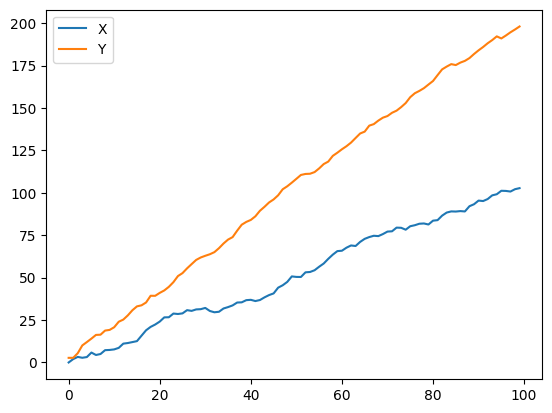

In [22]:
np.random.seed(123)
X = np.random.normal(1, 1, 100)
Y = np.random.normal(2, 1, 100)

X = pd.Series(np.cumsum(X), name='X')
Y = pd.Series(np.cumsum(Y), name='Y')

pd.concat([X, Y], axis=1).plot()

In [23]:
from statsmodels.tsa.stattools import coint
# calculate the correlation coefficeint
print('Correlation: ' + str(X.corr(Y)))
# perform in cointegration test
score, pvalue, _ = coint(X,Y)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.994833254077976
Cointegration test p-value: 0.17830098966789215


# Implement pairs trading

In [24]:
# download data from yfinance
stocks = ['GOOG','MSFT','AAPL','TSLA','META','NFLX']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,GOOG,META,MSFT,NFLX,TSLA
Date,,,,,,
2022-01-03,180.434296,145.074493,338.540009,330.092255,597.369995,399.926666
2022-01-04,178.144302,144.416504,336.529999,324.432159,591.150024,383.196655
2022-01-05,173.405685,137.653503,324.170013,311.977844,567.520020,362.706665
2022-01-06,170.510956,137.550995,332.459991,309.512634,553.289978,354.899994
2022-01-07,170.679489,137.004501,331.790009,309.670410,541.059998,342.320007


## Perform cointegration test

In [25]:
from itertools import combinations

# get all pairs of stocks
stock_pairs = list(combinations(df.columns, 2))
stock_pairs

[('AAPL', 'GOOG'),
 ('AAPL', 'META'),
 ('AAPL', 'MSFT'),
 ('AAPL', 'NFLX'),
 ('AAPL', 'TSLA'),
 ('GOOG', 'META'),
 ('GOOG', 'MSFT'),
 ('GOOG', 'NFLX'),
 ('GOOG', 'TSLA'),
 ('META', 'MSFT'),
 ('META', 'NFLX'),
 ('META', 'TSLA'),
 ('MSFT', 'NFLX'),
 ('MSFT', 'TSLA'),
 ('NFLX', 'TSLA')]

In [26]:
threshold = 0.1
# run Engle-Granger test for cointegration on each pair of stocks
for pair in stock_pairs:
    # subset df based on current pair of stocks
    df2 = df[list(pair)]
    # perform test for the current pair of stocks
    score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])
    # check if the current pair of stocks is cointegrated
    if pvalue < threshold:
        print(pair, 'are cointegrated')
    else:
        print(pair, 'are not cointegrated')

('AAPL', 'GOOG') are not cointegrated
('AAPL', 'META') are not cointegrated
('AAPL', 'MSFT') are not cointegrated
('AAPL', 'NFLX') are not cointegrated
('AAPL', 'TSLA') are not cointegrated
('GOOG', 'META') are not cointegrated
('GOOG', 'MSFT') are cointegrated
('GOOG', 'NFLX') are not cointegrated
('GOOG', 'TSLA') are not cointegrated
('META', 'MSFT') are not cointegrated
('META', 'NFLX') are not cointegrated
('META', 'TSLA') are not cointegrated
('MSFT', 'NFLX') are not cointegrated
('MSFT', 'TSLA') are not cointegrated
('NFLX', 'TSLA') are not cointegrated


## Obtain spread series

<Axes: xlabel='Date'>

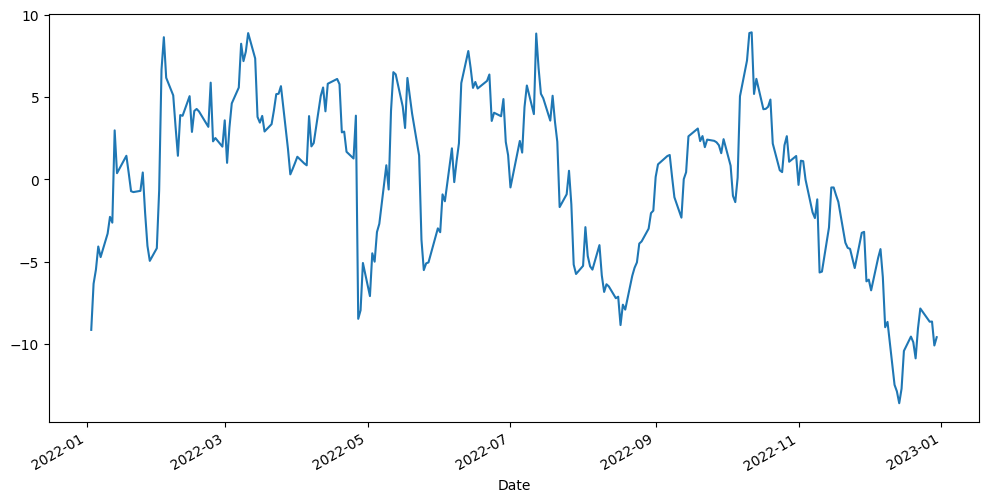

In [27]:
# calculate the spread for GOOG and MSFT
Y = df["GOOG"]
X = df["MSFT"]
# estimate linear regression coefficients
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
# obtain the spread as the residuals
spread = Y - model.predict()
spread.plot(figsize=(12,6))

## Converting to z-scores

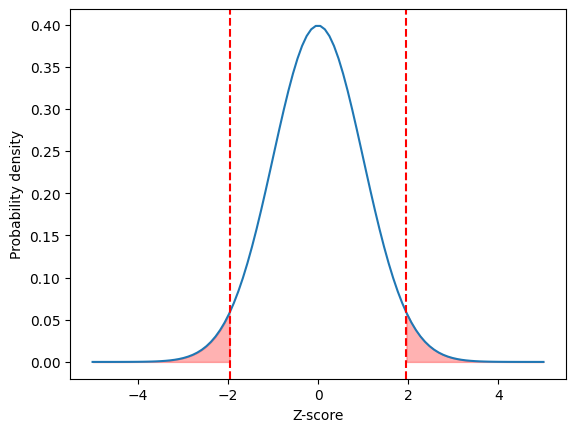

In [28]:
# illustrate z score by generating a standard normal distribution with mu 0 and sd 1
from scipy.stats import norm
# input: unbounded scalar, assumed to be in the range of [-5,-5] in this case
x = np.linspace(-5, 5, 100)
# output: probability between 0 and 1
y = norm.pdf(x, loc=0, scale=1)
# set up the plot
fig, ax = plt.subplots()
# plot the pdf of normal distribution
ax.plot(x, y)
# shade the area corresponding to a z-score of >=1.96 and <=-1.96
z_critical = 1.96
x_shade = np.linspace(z_critical, 5, 100)
y_shade = norm.pdf(x_shade, loc=0, scale=1)
ax.fill_between(x_shade, y_shade, color='red', alpha=0.3)
z_critical2 = -1.96
x_shade2 = np.linspace(-5, z_critical2, 100)
y_shade2 = norm.pdf(x_shade2, loc=0, scale=1)
ax.fill_between(x_shade2, y_shade2, color='red', alpha=0.3)
# add labels and a title
ax.set_xlabel('Z-score')
ax.set_ylabel('Probability density')
# add a vertical line to indicate the z-score of 1.96 and -1.96
ax.axvline(x=z_critical, linestyle='--', color='red')
ax.axvline(x=z_critical2, linestyle='--', color='red')
# display the plot
plt.show()

<Axes: xlabel='Date'>

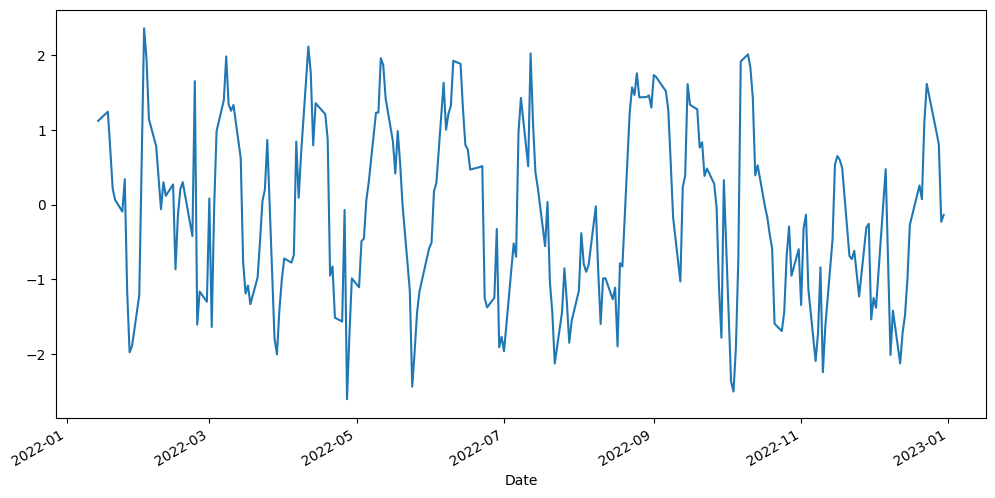

In [29]:
# convert to z score
# z-score is a measure of how many standard deviations the spread is from its mean
# derive mean and sd using a moving window
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = (spread - spread_mean) / spread_std
zscore.plot(figsize=(12,6))

In [30]:
# remove initial days with NA
first_valid_idx = zscore.first_valid_index()
zscore = zscore[first_valid_idx:]

In [31]:
zscore

Date
2022-01-14    1.123743
2022-01-18    1.245479
2022-01-19    0.742029
2022-01-20    0.211881
2022-01-21    0.064888
                ...   
2022-12-23    1.618936
2022-12-27    0.977237
2022-12-28    0.807606
2022-12-29   -0.230088
2022-12-30   -0.137040
Name: GOOG, Length: 242, dtype: float64

## Formulating trading strategy